
# Desafio Quant - Seven Pounds Asset Management
---


In [2]:
!pip install numpy pandas seaborn matplotlib scikit-learn yfinance

/bin/bash: line 1: numpy: command not found


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import yfinance as yf
import datetime
%matplotlib inline
import statsmodels.api as sm

## Introdução
---
Como referência, foi utilizada a data de 9 de outubro de 2025. Serão analisadas as ações da Amazon (AMZN), Walmart (WMT) e Google (GOOGL). O estudo consistirá em quatro análises a serem feitas a seguir:
- 1. Cálculo do Beta da Amazon em relação ao S&P 500
- 2. Correlação entre Amazon Walmart e Google e teste de significância
- 3. Análise Fundamental
- 4. Volatilidade e Risco

## 1. Beta
---
O fator beta é um indicador que pode medir a volatilidade de um ativo em relação a uma outra variável. Para calculá-lo foram utilizados duas metodologias:

Método 1: cálculo baseado na relação estatística
$$
  β: \frac{covariance(r_{1},r_{2})}{variance(r_{1})}
$$

Método 2: cálculo do coeficiente angular da regressão linear
<br>
<p>


In [ ]:
from sklearn.linear_model import LinearRegression

Beta from covariance = 1.3612


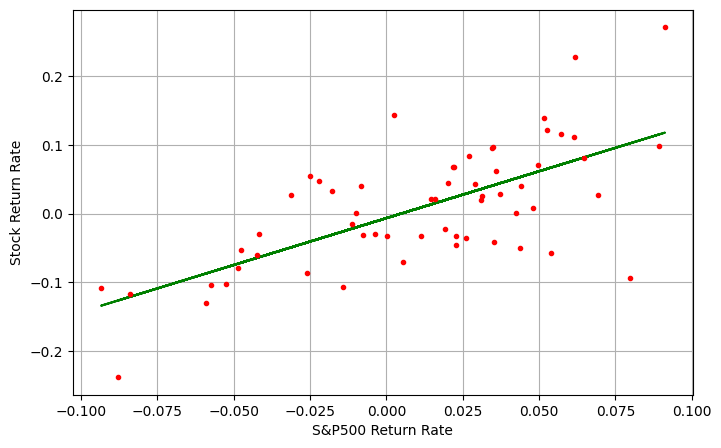

Beta from LinearRegression: 1.3612


In [ ]:
def calculate_return(Ticker, PriceColumn="Close", Period="5y", EndDate="2025-10-09", Interval="1mo"):
  Stock = yf.Ticker(Ticker)
  StockData = Stock.history(period = Period, end = EndDate,interval = Interval)
  StockData.drop(['Open','High','Low','Volume','Stock Splits'],axis=1,inplace=True)
  StockData['Return'] = (StockData['Close']+ StockData['Dividends'])/StockData['Close'].shift(1) -1
  StockData = StockData.rename(columns={'Return':Ticker}).drop(columns={'Close','Dividends'})

  StockData = StockData.dropna(subset=Ticker)
  return StockData

AmazonReturns = calculate_return("AMZN")
SP500Returns = calculate_return("^GSPC")

x = SP500Returns["^GSPC"]
y = AmazonReturns["AMZN"]

SP500_series = SP500Returns[["^GSPC"]]
Amazon_series = AmazonReturns.AMZN

# Metodo 1 - Calculate the covariance matrix
covarianceR1_R2 = y.cov(x)
varianceR1 = x.var()
print(f"Beta from covariance = {covarianceR1_R2/varianceR1:.4f}")


# Metodo 2 - Linear Regression
def calculate_beta(X, Y,x,y):
  lm = LinearRegression().fit(X,Y)
  Y_predict = lm.predict(X)

  plt.figure(figsize=(8,5))
  plt.grid(True, axis="both")
  plt.plot(X,Y_predict,'-',color='green',label='Linear Regression')
  plt.plot(x,y,'ro',markersize='3',label='Historical Returns')
  plt.xlabel("S&P500 Return Rate")
  plt.ylabel("Stock Return Rate")
  plt.show()

  return print(f"Beta from LinearRegression: {lm.coef_[0]:.4f}")
calculate_beta(SP500_series,Amazon_series,x,y)




## Cálculo de Correlação
---
Para as análises assumimos o período de 5 anos de série histórica como feito no item anterior.
<br>
A correlação (𝜌) foi calculada conforme a fórmula. Foi utilizado também o método .corr() do pandas, para comparação.
<p>
<p>
$$
\rho = \frac{Cov(x_{1},x_{2})}{σ_{1}*σ{2}}
$$
<p>

### Interpretação da correlação

Geramos duas hipóteses, a hipótese nula e a hipótese alternativa
Para testar as hipóteses de correlação foram feitos os testes t e o teste do p-valor.
O objetivo dos testes é verificar se a análise tem significância estatística linear.
Os resultados indicam que ambas as correlações são estatisticamente significativas (p < 0,05), portanto, não ocorrem por acaso.

* Amazon × Walmart: r=0.43, t=3.68, p = 0.00031 → há uma correlação positiva moderada, mostrando que os retornos das duas empresas tendem a se mover na mesma direção, embora não de forma muito forte.

* Amazon × Google:
r=0.77, t = 10.36, p≈0.00000 → existe uma correlação positiva forte e altamente significativa, indicando que os preços das ações variam de maneira bastante semelhante.

Assim, conclui-se que os retornos da Amazon estão claramente relacionados aos de ambas as empresas, mas a relação é muito mais intensa com o Google. Podemos concluir que as ações se comportam de forma semelhante


Amazon and Walmart correlation coefficient: 0.2681
Amazon and Google correlation coefficient: 0.6167
Correlação entre os ativos:
           AMZN       WMT     GOOGL
AMZN   1.000000  0.268064  0.616656
WMT    0.268064  1.000000  0.202805
GOOGL  0.616656  0.202805  1.000000 



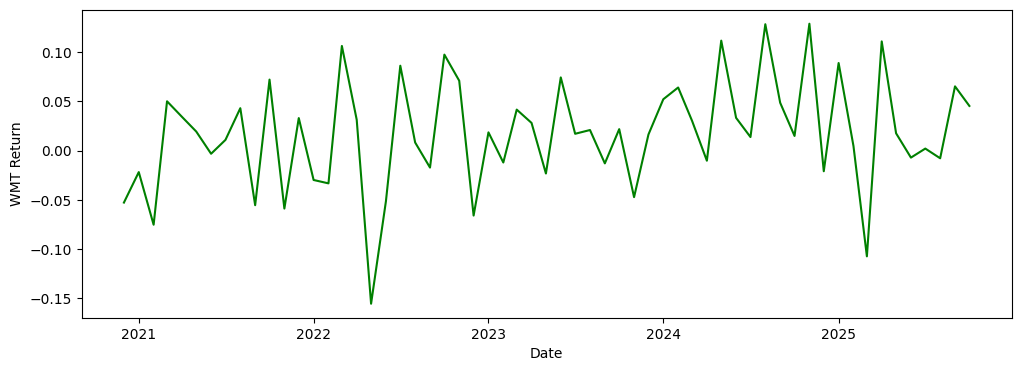

In [ ]:

WalMartReturns = calculate_return("WMT")
GoogleReturns = calculate_return("GOOGL")


def calculate_correlation(Stock_A, Stock_B):
  covariance_A_B = Stock_A.iloc[:,0].cov(Stock_B.iloc[:,0])
  std_A = Stock_A.iloc[:,0].std()
  std_B = Stock_B.iloc[:,0].std()

  correlation = covariance_A_B/(std_A*std_B)
  return correlation

def merge_returns(df_A,df_B,df_C):
  df_correlation = pd.merge(df_A,df_B,on='Date',how='inner')
  df_correlation = pd.merge(df_correlation,df_C,on='Date',how='inner')
  return df_correlation

df_correlation = merge_returns(AmazonReturns,WalMartReturns,GoogleReturns)

# (i) a. Correlação entre Amazon e Walmart
corr_AMZN_WMT = calculate_correlation(AmazonReturns,WalMartReturns)

print(f"Amazon and Walmart correlation coefficient: {corr_Amzn_Wal:.4f}")

# (i) b. Correlação entre Amazon e Google

corr_AMZN_GOOGL = calculate_correlation(AmazonReturns,GoogleReturns)

print(f"Amazon and Google correlation coefficient: {corr_Amzn_Googl:.4f}")


corr_matrix = df_correlation.corr()
print("Correlação entre os ativos:")
print(corr_matrix, "\n")

def plot_returns(ticker):
  plt.figure(figsize = (12,4))
  plt.plot(df_correlation.index,df_correlation[ticker],'-',color='green')
  plt.xlabel("Date")
  plt.ylabel(f"{ticker} Return")
  plt.show()
  return None

plot_returns('WMT')

In [ ]:
from scipy.stats import t

# (ii) Significância estatística, testar causalidade ou correlação simples.
def corr_pvalue(r, n):
    """
    Calcula o p-valor para uma correlação de Pearson r
    assumindo distribuição normal dos dados.
    """
    # Teste T
    t_stat = r * ((n - 2) / (1 - r**2))**0.5

    # P-valor
    p_value = 2 * (1 - t.cdf(abs(t_stat), df=n - 2))
    return t_stat, p_value

n = df_correlation.size

t_stat_WMT_AMZN, p_value_WMT_AMZN = corr_pvalue(r=corr_AMZN_WMT,n = n)
t_stat_GOOGL_AMZN, p_value_GOOGL_AMZN = corr_pvalue(r=corr_AMZN_GOOGL,n = n)

print(f"WMT x AMZN: t = {t_stat_WMT_AMZN:.4f}, p = {p_value_WMT_AMZN:.5f}")
print(f"GOOGL x AMZN: t = {t_stat_GOOGL_AMZN:.4f}, p = {p_value_GOOGL_AMZN:.5f}")

WMT x AMZN: t = 3.6809, p = 0.00031
GOOGL x AMZN: t = 10.3624, p = 0.00000


## 3. Análise Fundamental
---
A Amazon atua em dois segmentos principais: serviços de computação em nuvem (AWS) e comércio eletrônico. Essa diversificação posiciona a empresa em um ponto de interseção entre setores distintos, competindo tanto com o Walmart, no varejo digital, quanto com o Google e outras big techs, no setor de tecnologia e infraestrutura em nuvem.

Na análise de correlações entre retornos de ações, observou-se que os retornos da Amazon e da Google apresentam alta correlação, evidenciando que ambas as empresas tendem a seguir tendências semelhantes de valorização e desvalorização. Essa relação indica que o desempenho de mercado da Amazon está mais fortemente associado ao segmento tecnológico, especialmente aos serviços de cloud computing e publicidade digital, do que às atividades puramente de varejo. A análise de significância estatística reforça essa conclusão, mostrando que a relação entre Amazon e Google é consistente e relevante do ponto de vista estatístico e econômico.

Por outro lado, a correlação entre Amazon e Walmart, embora positiva, mostrou-se menos intensa, refletindo a diferença estrutural entre os modelos de negócio. Enquanto o Walmart mantém foco predominante no varejo físico e na eficiência logística, a Amazon tem ampliado suas receitas e margens por meio da tecnologia, serviços de assinatura e infraestrutura digital, que apresentam dinâmicas de mercado distintas.

O beta da Amazon, estimado em 1,36, indica alta sensibilidade em relação ao mercado (S&P 500). Isso significa que, em períodos de valorização do índice, a Amazon tende a apresentar ganhos superiores à média, enquanto em momentos de queda generalizada, sofre desvalorizações mais acentuadas.

Em resumo, a análise demonstra que o desempenho da Amazon está mais alinhado às tendências do setor de tecnologia do que ao varejo tradicional, o que reforça sua natureza híbrida — uma companhia que, apesar de forte no e-commerce, é hoje impulsionada pelos resultados da AWS e dos serviços digitais.


## 4. Análise de Volatilidade
---

Foi calculada a volatilidade diária média dos últimos 5 anos, que corresponde ao desvio padrão da série histórica. Mas para a análise de risco foi analisada a volatilidade anual pois faria mais sentido para comparar análises de longo prazo, para assim decidir qual é mais arriscada.

In [ ]:
tickers = ['AMZN', 'GOOGL', 'WMT']
AMZN_daily = calculate_return(tickers[0],Interval = "1d")
WMT_daily = calculate_return(tickers[1],Interval = "1d")
GOOGL_daily = calculate_return(tickers[2],Interval = "1d")

df_volatile = merge_returns(AMZN_daily,WMT_daily,GOOGL_daily)

# volatilidade média diária
df_volatile.std()
print("Volatilidade média diária\n",df_volatile.std())
# volatilidade anual (252 dias úteis)
anual_volatile = df_volatile.std() * np.sqrt(252)
print("Volatilidade média anual\n",anual_volatile)



Volatilidade média diária
 AMZN     0.022069
GOOGL    0.019539
WMT      0.012921
dtype: float64
Volatilidade média anual
 AMZN     0.350341
GOOGL    0.310167
WMT      0.205113
dtype: float64


## Conclusões
---
Com base nos valores calculados, observa-se que a Amazon apresenta a maior volatilidade média dos retornos nos últimos cinco anos. Além disso, seu beta elevado indica maior sensibilidade ao desempenho do mercado, especialmente ao movimento do S&P 500. Em conjunto, esses fatores evidenciam que a Amazon possui o nível de risco mais elevado entre as empresas analisadas.
Sua atuação em setores como tecnologia, computação em nuvem e e-commerce, faz com que seus retornos sejam fortemente impactados por mudanças nas condições macroeconômicas e nas expectativas de crescimento global.

Em contraste, o Walmart apresenta um perfil mais estável, caracterizado por menor volatilidade.
Já a Google ocupa uma posição intermediária resultando em um risco moderado.

Apesar de ser uma métrica central para avaliar o comportamento dos retornos, a volatilidade não deve ser analisada isoladamente. Outros elementos também influenciam o risco de uma empresa, como:

* Riscos sistemáticos de mercado, refletidos pelo beta e pelas condições macroeconômicas;
* Riscos financeiros, associados à estrutura de capital e à alavancagem;
* Riscos operacionais e regulatórios, decorrentes de mudanças legais, concorrência e inovação tecnológica.

Portanto, a avaliação de risco deve integrar tanto indicadores quantitativos (como volatilidade e beta) quanto aspectos qualitativos relacionados à gestão, competitividade e fundamentos econômicos da empresa.


## References
---
1. https://algotrading101.com/learn/yahoo-finance-api-guide/
2. https://pages.stern.nyu.edu/~adamodar/podcasts/cfspr20/session7slides.pdf
3. https://www.investopedia.com/terms/c/correlationcoefficient.asp
4. https://en.wikipedia.org/wiki/Pearson_correlation_coefficient